# 1 FEATURE , PAST 10 YEAR , NEXT DAY PREDICTION WINDO SIZE=6

In [4]:
!pip install meteostat

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Flatten,BatchNormalization
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [5]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="jainam")

# Example city
city = "Ahmedabad, India"

location = geolocator.geocode(city)

if location:
    print(f"City: {city}")
    print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")
else:
    print(f"Could not find coordinates for {city}")


City: Ahmedabad, India
Latitude: 23.0215374, Longitude: 72.5800568


In [5]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2014, 6, 1)
end = datetime.datetime(2024, 6, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2014-06-01  35.3   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2014-06-02  36.4   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2014-06-03  37.6   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2014-06-04  36.8   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2014-06-05  36.8   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-05-28  34.4  29.0  43.4   0.0   NaN  214.0  15.5   NaN   999.4   NaN
2024-05-29  34.1  29.0  41.4   0.0   NaN  206.0  17.7   NaN   999.8   NaN
2024-05-30  34.3  30.0  43.0   0.0   NaN  201.0  13.6   NaN  1001.5   NaN
2024-05-31  34.4  30.0  42.4   0.0   NaN  198.0  15.7   NaN  1003.3   NaN
2024-06-01  34.5  30.0  41.6   0.0   NaN  203.0  14.7   NaN  1003.3   NaN

[3654 rows x 10 columns]


In [6]:
temperature_avg=data[["tavg"]]


In [7]:
print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())

TOTAL NULL VALUES IN DATASET: tavg    6
dtype: int64


In [8]:
temperature_avg.dropna(inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
temperature_avg.describe()

,tavg
count,3648.000000
mean,28.024205
std,5.067843
min,14.800000
25%,24.200000
50%,28.800000
75%,31.600000
max,39.300000


In [10]:
temperature_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3648 entries, 2014-06-01 to 2024-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    3648 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [11]:
temperature_avg_seq=temperature_avg.values
print(temperature_avg_seq,temperature_avg_seq.shape)

[[35.3]
 [36.4]
 [37.6]
 ...
 [34.3]
 [34.4]
 [34.5]] (3648, 1)


In [12]:
len(temperature_avg_seq)

3648

In [31]:
def plot_loss_curves(history):
    """
    Plots the loss curves of a model
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['mae']
    val_accuracy = history.history['val_mae']

    epochs = range(len(history.history['loss']))


    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [14]:
window_size=6
X=[]
Y=[]
for i in range(len(temperature_avg_seq)-window_size):
  X.append(temperature_avg_seq[i:i+window_size])
  Y.append(temperature_avg_seq[i+window_size])


In [15]:
X=np.array(X)
Y=np.array(Y)


In [16]:
print("X Shape",X.shape)
print("Y Shape",Y.shape)


X Shape (3642, 6, 1)
Y Shape (3642, 1)


In [17]:
X_scaler=MinMaxScaler()
Y_scaler=MinMaxScaler()

X_flat = np.array(X).reshape(-1, 1)
Y_flat = np.array(Y).reshape(-1, 1)

X_scaled=X_scaler.fit_transform(X_flat).reshape(len(X),6,1)
Y_scaled=Y_scaler.fit_transform(Y_flat).reshape(len(Y),1)

In [18]:
print("X_scaled Shape",X_scaled.shape)
print("Y_scaled Shape",Y_scaled.shape)


X_scaled Shape (3642, 6, 1)
Y_scaled Shape (3642, 1)


In [20]:
naive_model=Sequential()
naive_model.add(LSTM(128,return_sequences=True,input_shape=(window_size,1)))
naive_model.add(Dropout(0.2))
naive_model.add(LSTM(64,return_sequences=True))
naive_model.add(Dropout(0.2))
naive_model.add(LSTM(32))
naive_model.add(Dropout(0.2))
naive_model.add(Dense(1))

In [21]:
naive_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 6, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 6, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,417 (501.63 KB)

 Trainable params: 128,417 (501.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
naive_model.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [23]:
history=naive_model.fit(np.array(X_scaled).reshape(-1,window_size,1),Y_scaled,epochs=100,batch_size=16,validation_split=0.2)

Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0622 - mae: 0.1741 - val_loss: 0.0052 - val_mae: 0.0569
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - mae: 0.0788 - val_loss: 0.0058 - val_mae: 0.0590
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - mae: 0.0755 - val_loss: 0.0052 - val_mae: 0.0556
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - mae: 0.0768 - val_loss: 0.0047 - val_mae: 0.0541
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - mae: 0.0696 - val_loss: 0.0047 - val_mae: 0.0526
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078 - mae: 0.0694 - val_loss: 0.0041 - val_mae: 0.0495
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - mae: 0.0659 - val_loss: 0.0041 - val_mae: 0.0515
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - mae: 0.0648 - val_loss: 0.0035 - val_mae: 0.0460
Epoch 9/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/

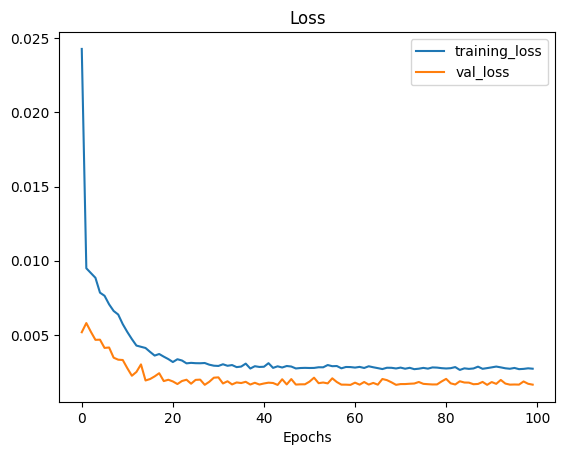

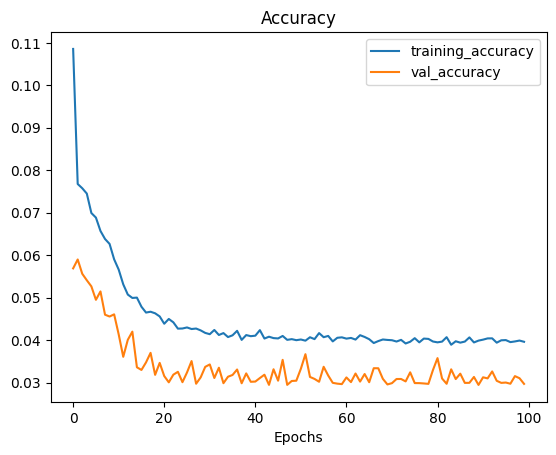

In [24]:
plot_loss_curves(history)

In [29]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2024, 12, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-06-01  34.5  30.0  41.6   0.0   NaN  203.0  14.7   NaN  1003.3   NaN
2024-06-02  34.5  30.0  41.4   0.0   NaN  212.0  10.9   NaN  1004.4   NaN
2024-06-03  34.8  30.0  41.6   0.0   NaN  220.0  11.6   NaN  1003.9   NaN
2024-06-04  34.8  30.0  41.4   0.0   NaN  227.0  15.0   NaN  1004.4   NaN
2024-06-05  34.5  29.0  41.4   0.0   NaN  223.0  14.3   NaN  1005.1   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-11-27  22.9  16.0  30.0   0.0   NaN   37.0   5.9   NaN  1013.2   NaN
2024-11-28  23.6  18.0  30.0   0.0   NaN   40.0   6.4   NaN  1013.1   NaN
2024-11-29  22.3  18.0  28.0   0.0   NaN   27.0  12.1   NaN  1014.1   NaN
2024-11-30  21.0  16.0  27.0   0.0   NaN   20.0  13.3   NaN  1012.8   NaN
2024-12-01  21.2  15.0  28.0   0.0   NaN   31.0  13.9   NaN  1010.9   NaN

[184 rows x 10 columns]


In [30]:
print(data.shape)

(184, 10)


In [31]:
next_6_months_temp=data["tavg"]


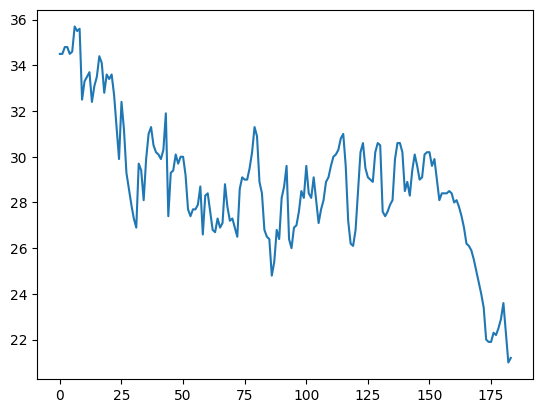

In [32]:
plt.plot(next_6_months_temp.values.flatten())

In [69]:
location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 5, 26)
end = datetime.datetime(2024, 5, 31)

# Get historical data
data_for_model = Daily(location, start, end)
data_for_model = data_for_model.fetch()

print(data_for_model)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-05-26  35.9  30.0  43.0   0.0   NaN  235.0  14.3   NaN  1000.6   NaN
2024-05-27  35.2  29.0  45.0   0.0   NaN  221.0  13.9   NaN   999.1   NaN
2024-05-28  34.4  29.0  43.4   0.0   NaN  214.0  15.5   NaN   999.4   NaN
2024-05-29  34.1  29.0  41.4   0.0   NaN  206.0  17.7   NaN   999.8   NaN
2024-05-30  34.3  30.0  43.0   0.0   NaN  201.0  13.6   NaN  1001.5   NaN
2024-05-31  34.4  30.0  42.4   0.0   NaN  198.0  15.7   NaN  1003.3   NaN


In [70]:
data_for_model["tavg"].values

array([35.9, 35.2, 34.4, 34.1, 34.3, 34.4])

In [71]:
data_for_model=X_scaler.transform(np.array(data_for_model["tavg"].values).reshape(-1,1))


In [72]:
data_for_model=data_for_model.reshape(1,6,1)

In [75]:
copied=data_for_model.copy()
copied=copied[1:]
copied = np.append(copied, 1.2)
copied

array([0.83265306, 0.8       , 0.7877551 , 0.79591837, 0.8       ,
       1.2       ])

In [74]:
data_for_model=data_for_model.flatten()

In [76]:
data_for_model

array([0.86122449, 0.83265306, 0.8       , 0.7877551 , 0.79591837,
       0.8       ])

In [77]:
output=[]
for i in range(184):
    print(data_for_model)

    prediction = naive_model.predict(np.array(data_for_model).reshape(-1, window_size, 1))
    prediction_original = Y_scaler.inverse_transform(prediction.reshape(1, -1))
    output.append(prediction_original[0, 0])
    data_for_model = np.append(data_for_model[1:], prediction)

[0.86122449 0.83265306 0.8        0.7877551  0.79591837 0.8       ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
[0.83265306 0.8        0.7877551  0.79591837 0.8        0.79534328]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8        0.7877551  0.79591837 0.8        0.79534328 0.78833389]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.7877551  0.79591837 0.8        0.79534328 0.78833389 0.78208059]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.79591837 0.8        0.79534328 0.78833389 0.78208059 0.77802241]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.8        0.79534328 0.78833389 0.78208059 0.77802241 0.77534229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.79534328 0.78833389 0.78208059 0.77802241 0.77534229 0.77279735]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.78833389 0.78208059 0.77802241 0.77534229 0.77279735 0.76998913]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.78208059 0.77802241 0.77534229 0.77279735 0.76998913 0.76708901]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.77802241 0.77534229 0.77279735 0.76998913 

In [88]:
next_6_months_temp=list(next_6_months_temp.values)

In [90]:
print("Len Output:",len(output))
print("Len next_6_months_temp:",len(next_6_months_temp))


Len Output: 184
Len next_6_months_temp: 184


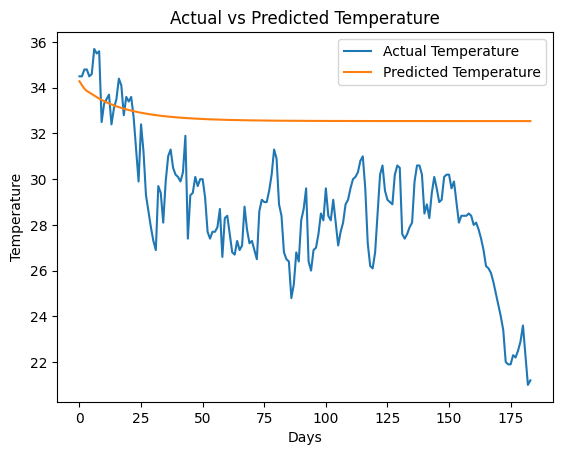

In [92]:

# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(list(next_6_months_temp), label="Actual Temperature")
plt.plot(list(output), label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [91]:
from sklearn.metrics import r2_score
r2_score(list(next_6_months_temp),output)

-1.6720556422151054

In [93]:
naive_model.save("naive_model.h5")

# 1 FEATURE , PAST 27 YEAR , NEXT DAY PREDICTION WINDO SIZE=100

In [ ]:
"""
JUST CHANGE data[feature] : feature with tmin,tmax,tavg 
                            and change Scaler with Standard Scaler and MinMax Scaler
                            remain all other code same 

And You wil get result as i got which i mentioned in All model evalution portion.

"""

In [368]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(1990, 6, 1)
end = datetime.datetime(2024, 6, 1)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
1990-06-01  30.1  23.6  37.6  14.0   NaN    NaN   NaN   NaN     NaN   NaN
1990-06-02  32.0  27.6  38.2   0.0   NaN    NaN   NaN   NaN     NaN   NaN
1990-06-03  32.1  27.6   NaN   0.3   NaN    NaN   NaN   NaN     NaN   NaN
1990-06-04  33.4  28.4  40.4   0.0   NaN    NaN   NaN   NaN     NaN   NaN
1990-06-05  31.7  27.6   NaN   0.3   NaN    NaN   NaN   NaN     NaN   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-05-28  34.4  29.0  43.4   0.0   NaN  214.0  15.5   NaN   999.4   NaN
2024-05-29  34.1  29.0  41.4   0.0   NaN  206.0  17.7   NaN   999.8   NaN
2024-05-30  34.3  30.0  43.0   0.0   NaN  201.0  13.6   NaN  1001.5   NaN
2024-05-31  34.4  30.0  42.4   0.0   NaN  198.0  15.7   NaN  1003.3   NaN
2024-06-01  34.5  30.0  41.6   0.0   NaN  203.0  14.7   NaN  1003.3   NaN

[12420 rows x 10 columns]


In [369]:
temperature_avg=data["tmin"]

In [370]:
print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())

TOTAL NULL VALUES IN DATASET: 3011


In [371]:
temperature_avg.dropna(inplace=True)

In [372]:
temperature_avg.describe()

count    9409.000000
mean       21.371708
std         5.754475
min         4.000000
25%        16.600000
50%        23.500000
75%        26.000000
max        31.600000
Name: tmin, dtype: float64

In [373]:
temperature_avg.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 9409 entries, 1990-06-01 to 2024-06-01
Series name: tmin
Non-Null Count  Dtype  
--------------  -----  
9409 non-null   float64
dtypes: float64(1)
memory usage: 147.0 KB


In [374]:
temperature_avg_seq=temperature_avg.values
print(temperature_avg_seq,temperature_avg_seq.shape)

[23.6 27.6 27.6 ... 30.  30.  30. ] (9409,)


In [375]:

window_size=100

X=[]
Y=[]
for i in range(len(temperature_avg_seq)-window_size):
  X.append(temperature_avg_seq[i:i+window_size])
  Y.append(temperature_avg_seq[i+window_size])

In [376]:
X=np.array(X)
Y=np.array(Y)

In [377]:
print("X Shape",X.shape)
print("Y Shape",Y.shape)


X Shape (9309, 100)
Y Shape (9309,)


In [378]:
X

array([[23.6, 27.6, 27.6, ..., 23.7, 23.4, 25. ],
       [27.6, 27.6, 28.4, ..., 23.4, 25. , 24.8],
       [27.6, 28.4, 27.6, ..., 25. , 24.8, 23.8],
       ...,
       [20. , 21. , 20. , ..., 29. , 29. , 29. ],
       [21. , 20. , 15. , ..., 29. , 29. , 30. ],
       [20. , 15. , 14. , ..., 29. , 30. , 30. ]])

In [379]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [380]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)


In [381]:
X_train

array([[26.8, 26.8, 26.6, ..., 16. , 13.4, 14.8],
       [25.8, 25.8, 26.2, ..., 13. , 15. , 11.5],
       [20.2, 18. , 17. , ..., 15. , 16.8, 13. ],
       ...,
       [28.5, 27.6, 28.5, ..., 23.4, 23.4, 23.8],
       [17.7, 19. , 19.2, ..., 22.9, 25.4, 27.4],
       [25.2, 25.1, 25.7, ..., 21.8, 17.9, 19. ]])

In [382]:
from sklearn.preprocessing import StandardScaler
MinMax=MinMaxScaler()
X_train_Scaled=MinMax.fit_transform(X_train.reshape(-1,1))
X_test_Scaled=MinMax.transform(X_test.reshape(-1,1))

In [383]:
X_train=X_train_Scaled.reshape(X_train.shape[0],100)

In [384]:
X_test=X_test_Scaled.reshape(X_test.shape[0],100)

In [385]:
print("X_train Shape",X_train.shape)
print("X_test Shape",X_test.shape)
print("Y_train Shape",Y_train.shape)
print("Y_test Shape",Y_test.shape)


X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)


In [386]:
maxLength=6
upgraded_naive_model=Sequential()
upgraded_naive_model.add(LSTM(128,return_sequences=True,input_shape=(window_size,1)))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100,return_sequences=True))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100,return_sequences=True))
upgraded_naive_model.add(Dropout(0.2))
upgraded_naive_model.add(LSTM(100))
upgraded_naive_model.add(Dropout(0.2))

upgraded_naive_model.add(Dense(64,activation="relu"))
upgraded_naive_model.add(Dropout(0.2))


upgraded_naive_model.add(Dense(1))


In [387]:
upgraded_naive_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 100, 100)            │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,489 (1.24 MB)

 Trainable params: 325,489 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [388]:
upgraded_naive_model.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [389]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "temperature_best_min_MinMax.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

In [390]:
X_test.shape, Y_test.shape

((2793, 100), (2793,))

In [391]:
history=upgraded_naive_model.fit(np.array(X_train).reshape(-1,window_size,1),Y_train,epochs=50,batch_size=16,validation_data=(X_test,Y_test),callbacks=[checkpoint])

Epoch 1/50
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 90.1420 - mae: 7.3374
Epoch 1: val_loss improved from inf to 33.00687, saving model to temperature_best_min_MinMax.keras
408/408 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 89.8575 - mae: 7.3260 - val_loss: 33.0069 - val_mae: 4.9510
Epoch 2/50
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 38.4391 - mae: 5.1804
Epoch 2: val_loss improved from 33.00687 to 32.95997, saving model to temperature_best_min_MinMax.keras
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 38.4444 - mae: 5.1811 - val_loss: 32.9600 - val_mae: 5.0634
Epoch 3/50
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 39.0178 - mae: 5.3156
Epoch 3: val_loss did not improve from 32.95997
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 39.0144 - mae: 5.3152 - val_loss: 34.3803 - val_mae: 5.2415
Epoch 4/50
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 39.0488 - mae: 5.3273
Epoch 4: val_loss improved from 32.95997 to 32.89360, saving model to temperature_best

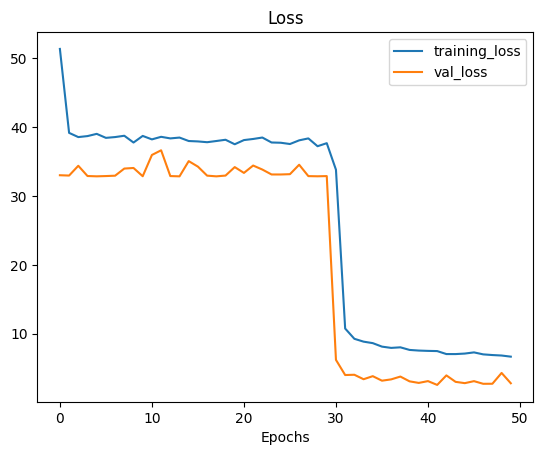

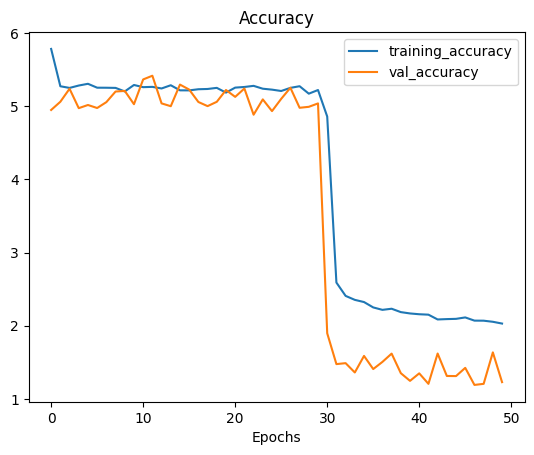

In [392]:
plot_loss_curves(history)

In [393]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [394]:
from meteostat import Point, Daily
import datetime


location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2024, 6, 30)

# Get historical data
data = Daily(location, start, end)
data = data.fetch()

print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-06-01  34.5  30.0  41.6   0.0   NaN  203.0  14.7   NaN  1003.3   NaN
2024-06-02  34.5  30.0  41.4   0.0   NaN  212.0  10.9   NaN  1004.4   NaN
2024-06-03  34.8  30.0  41.6   0.0   NaN  220.0  11.6   NaN  1003.9   NaN
2024-06-04  34.8  30.0  41.4   0.0   NaN  227.0  15.0   NaN  1004.4   NaN
2024-06-05  34.5  29.0  41.4   0.0   NaN  223.0  14.3   NaN  1005.1   NaN
2024-06-06  34.6  29.0  41.6   0.0   NaN  227.0  12.6   NaN  1005.7   NaN
2024-06-07  35.7  30.0  42.4   0.0   NaN  248.0  12.0   NaN  1003.6   NaN
2024-06-08  35.5  31.0  41.8   0.0   NaN  224.0  11.0   NaN  1002.4   NaN
2024-06-09  35.6  29.0  43.0   0.0   NaN  267.0  13.1   NaN  1001.9   NaN
2024-06-10  32.5  27.4  39.6   1.0   NaN  234.0  10.1   NaN  1003.5   NaN
2024-06-11  33.3  25.5  40.2  30.0   NaN  250.0  10.7   NaN  1003.5   NaN
2024-06-12  33.5  29.0  40.8   0.0   N

In [395]:
print(data.shape)

(30, 10)


In [396]:
next_6_months_temp=data["tmin"]


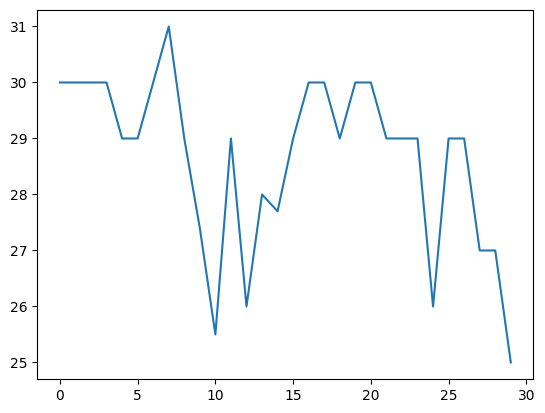

In [397]:
plt.plot(next_6_months_temp.values.flatten())

In [398]:
location = Point( 23.0215374, 72.5800568)
start = datetime.datetime(2024, 2, 22)
end = datetime.datetime(2024, 5, 31)

# Get historical data
data_for_model = Daily(location, start, end)
data_for_model = data_for_model.fetch()

print(data_for_model)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-02-22  24.2  20.0  29.8   0.0   NaN  266.0  10.0   NaN  1012.2   NaN
2024-02-23  22.6  15.0  30.0   0.0   NaN  347.0   5.7   NaN  1013.6   NaN
2024-02-24  22.1  14.0  30.0   0.0   NaN  327.0   6.7   NaN  1013.6   NaN
2024-02-25  22.4  13.0  30.6   0.0   NaN    6.0   9.5   NaN  1013.5   NaN
2024-02-26  23.9  19.0  30.0   0.0   NaN   29.0  11.7   NaN  1012.2   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-05-27  35.2  29.0  45.0   0.0   NaN  221.0  13.9   NaN   999.1   NaN
2024-05-28  34.4  29.0  43.4   0.0   NaN  214.0  15.5   NaN   999.4   NaN
2024-05-29  34.1  29.0  41.4   0.0   NaN  206.0  17.7   NaN   999.8   NaN
2024-05-30  34.3  30.0  43.0   0.0   NaN  201.0  13.6   NaN  1001.5   NaN
2024-05-31  34.4  30.0  42.4   0.0   NaN  198.0  15.7   NaN  1003.3   NaN

[100 rows x 10 columns]


In [399]:
data_for_model["tmin"].values

array([20. , 15. , 14. , 13. , 19. , 21. , 20. , 20. , 22. , 22. , 15. ,
       15. , 12. , 15. , 17. , 17. , 17. , 18.4, 20. , 22. , 21. , 21. ,
       20. , 19. , 22. , 22. , 19. , 21. , 22. , 20. , 23. , 24. , 23. ,
       23. , 25.1, 27. , 27. , 24. , 23. , 25. , 24. , 25. , 26. , 25. ,
       26. , 24. , 26. , 24. , 27. , 26. , 26. , 25. , 28. , 25. , 26. ,
       27. , 29. , 26.8, 25. , 26. , 26. , 25. , 27. , 27. , 28. , 27. ,
       28. , 29. , 27. , 26. , 23. , 26. , 29. , 29. , 27. , 28. , 29. ,
       29. , 29. , 29. , 29. , 25.8, 26. , 28. , 30. , 31. , 30. , 31. ,
       31. , 31. , 31. , 31. , 30. , 30. , 30. , 29. , 29. , 29. , 30. ,
       30. ])

In [400]:
data_for_model=MinMax.transform(np.array(data_for_model["tmin"].values).reshape(-1,1))


In [401]:
data_for_model=data_for_model.reshape(1,100,1)

In [402]:
data_for_model=data_for_model.flatten()
data_for_model

array([0.57971014, 0.39855072, 0.36231884, 0.32608696, 0.54347826,
       0.61594203, 0.57971014, 0.57971014, 0.65217391, 0.65217391,
       0.39855072, 0.39855072, 0.28985507, 0.39855072, 0.47101449,
       0.47101449, 0.47101449, 0.52173913, 0.57971014, 0.65217391,
       0.61594203, 0.61594203, 0.57971014, 0.54347826, 0.65217391,
       0.65217391, 0.54347826, 0.61594203, 0.65217391, 0.57971014,
       0.6884058 , 0.72463768, 0.6884058 , 0.6884058 , 0.76449275,
       0.83333333, 0.83333333, 0.72463768, 0.6884058 , 0.76086957,
       0.72463768, 0.76086957, 0.79710145, 0.76086957, 0.79710145,
       0.72463768, 0.79710145, 0.72463768, 0.83333333, 0.79710145,
       0.79710145, 0.76086957, 0.86956522, 0.76086957, 0.79710145,
       0.83333333, 0.9057971 , 0.82608696, 0.76086957, 0.79710145,
       0.79710145, 0.76086957, 0.83333333, 0.83333333, 0.86956522,
       0.83333333, 0.86956522, 0.9057971 , 0.83333333, 0.79710145,
       0.6884058 , 0.79710145, 0.9057971 , 0.9057971 , 0.83333

In [75]:
copied=data_for_model.copy()
copied=copied[1:]
copied = np.append(copied, 1.2)
copied

array([-1.01036587, -1.11302757, -1.05143055, -0.74344547, -0.41492805,
       -0.35333103, -0.04534595,  0.24210679, -0.41492805, -1.52367434,
       -1.40048031, -1.09249523, -0.82557483, -0.5997191 , -0.49705741,
       -0.41492805, -0.27120168, -0.00428128,  0.0367834 , -0.12747531,
       -0.08641063, -0.14800765, -0.04534595,  0.28317147,  0.28317147,
        0.09838042,  0.36530082,  0.38583316,  0.28317147,  0.52955953,
        0.44743018,  0.63222122,  0.7759476 ,  1.00180332,  1.042868  ,
        0.81701227,  0.50902719,  0.36530082,  0.46796251,  0.52955953,
        0.55009187,  0.52955953,  0.61168889,  0.73488292,  0.65275356,
        0.94020631,  0.98127098,  1.12499735,  0.96073864,  0.85807695,
        0.71435058,  0.79647993,  0.98127098,  1.12499735,  1.33032074,
        1.45351477,  1.042868  ,  0.71435058,  0.73488292,  0.87860929,
        0.96073864,  1.18659437,  1.26872373,  1.10446502,  1.06340034,
        1.18659437,  1.26872373,  1.14552969,  1.042868  ,  1.04

In [403]:
output=[]
for i in range(30):
    print(data_for_model)

    prediction = best_model.predict(np.array(data_for_model).reshape(-1, window_size, 1))
    
    output.append(prediction)
    data_for_model = np.append(data_for_model[1:], prediction)

[0.57971014 0.39855072 0.36231884 0.32608696 0.54347826 0.61594203
 0.57971014 0.57971014 0.65217391 0.65217391 0.39855072 0.39855072
 0.28985507 0.39855072 0.47101449 0.47101449 0.47101449 0.52173913
 0.57971014 0.65217391 0.61594203 0.61594203 0.57971014 0.54347826
 0.65217391 0.65217391 0.54347826 0.61594203 0.65217391 0.57971014
 0.6884058  0.72463768 0.6884058  0.6884058  0.76449275 0.83333333
 0.83333333 0.72463768 0.6884058  0.76086957 0.72463768 0.76086957
 0.79710145 0.76086957 0.79710145 0.72463768 0.79710145 0.72463768
 0.83333333 0.79710145 0.79710145 0.76086957 0.86956522 0.76086957
 0.79710145 0.83333333 0.9057971  0.82608696 0.76086957 0.79710145
 0.79710145 0.76086957 0.83333333 0.83333333 0.86956522 0.83333333
 0.86956522 0.9057971  0.83333333 0.79710145 0.6884058  0.79710145
 0.9057971  0.9057971  0.83333333 0.86956522 0.9057971  0.9057971
 0.9057971  0.9057971  0.9057971  0.78985507 0.79710145 0.86956522
 0.94202899 0.97826087 0.94202899 0.97826087 0.97826087 0.97826

In [404]:
next_6_months_temp=list(next_6_months_temp.values)

In [405]:
print("Len Output:",len(output))
print("Len next_6_months_temp:",len(next_6_months_temp))


Len Output: 30
Len next_6_months_temp: 30


In [302]:
list(np.array(output).flatten())

[42.26219,
 43.584137,
 43.63522,
 43.651714,
 43.65484,
 43.41555,
 43.422462,
 43.423683,
 43.413635,
 43.61869,
 43.50193,
 43.36956,
 43.212875,
 43.339005,
 43.33207,
 43.325966,
 43.320354,
 43.31549,
 43.31143,
 43.308105,
 43.3054,
 43.30322,
 43.301453,
 43.30001,
 43.298832,
 43.297867,
 43.297073,
 43.296406,
 43.295853,
 43.295387]

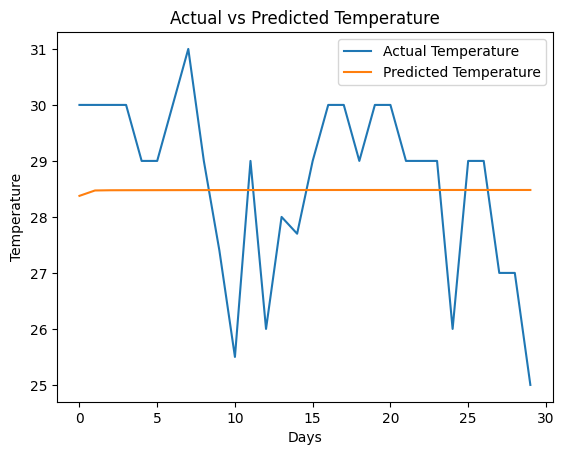

In [406]:

# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(list(next_6_months_temp), label="Actual Temperature")
plt.plot(list(np.array(output).flatten()), label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [407]:
from sklearn.metrics import r2_score,mean_squared_error
mean_squared_error(list(next_6_months_temp),list(np.array(output).flatten()))

2.339544878304781

In [408]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [409]:
len(y_prediction_x)

2793

In [44]:
y_pred_final=[]
for i in y_prediction_x:
  # print(i)
  y_pred_final.append(MinMax.inverse_transform(i.reshape(-1,1))[0,0])


In [779]:
y_true_final=[]

for i in Y_test:
  # print(i)
  y_true_final.append(MinMax_Loaded.inverse_transform(np.array(i).reshape(-1,1))[0,0])


In [850]:
y_true_final[0], y_pred_final[0], Y_test[0],y_prediction_x[0]

(28.4, 164.64227, 28.4, array([28.154232], dtype=float32))

In [730]:
len(y_true_final)

3028

In [410]:
mean_squared_error(Y_test,y_prediction_x)

2.565570408730117

In [386]:
len(y_true_final)

3028

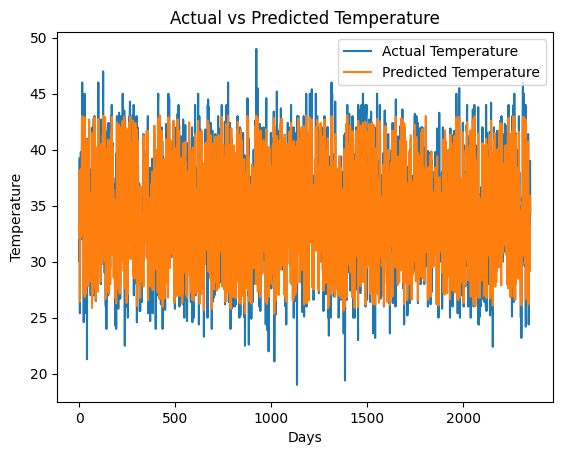

In [254]:


# Plot the two arrays
import matplotlib.pyplot as plt

plt.plot(Y_test, label="Actual Temperature")
plt.plot(y_prediction_x, label="Predicted Temperature")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()


In [411]:
import pickle as pkl

pkl.dump(MinMax,open("MinMaxScaler_min.pkl",'wb'))

In [66]:
MinMax_Loaded=pkl.load(open("/kaggle/working/MinMax_Avg.pkl","rb"))

# EVALUTION 

In [412]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error


In [413]:
def model_evaluation(y_true, y_pred):
    """Compute evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    medianae=median_absolute_error(y_true,y_pred)
    
    
    metrics = {
        "Mean Sqaured Error": mse,
        "Mean Absolute Error": mae,
        "Median Absolute Error": medianae
    }
    return metrics

In [414]:
def display_metrics(metrics, save_path=None):
    """Stylishly display metrics using Matplotlib and optionally save the plot."""
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.barh(list(metrics.keys()), list(metrics.values()), color="skyblue")
    ax.set_title("Model Evaluation Metrics", fontsize=16, fontweight="bold")
    ax.set_xlabel("Scores", fontsize=12)
    ax.set_xlim(0, 4)
    for i, v in enumerate(metrics.values()):
        ax.text(v + 0.01, i, f"{v:.2f}", color="black", va="center", fontsize=10)
    plt.tight_layout()
    
    # Save the plot if a save path is provided
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Metrics plot saved to {save_path}")
    plt.show()

In [415]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [420]:
r2_score(Y_test[:30],y_prediction_x[:30])

0.9278844664625172

## ALL MODEL EVALUTION

In [530]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error


In [489]:
from meteostat import Point, Daily
import datetime

def prepare_data(feature,scaler):    
    location = Point( 23.0215374, 72.5800568)
    start = datetime.datetime(1990, 6, 1)
    end = datetime.datetime(2024, 6, 1)
    
    # Get historical data
    data = Daily(location, start, end)
    data = data.fetch()
    
    
    temperature_avg=data[feature]
    print("TOTAL NULL VALUES IN DATASET:",temperature_avg.isnull().sum())
    temperature_avg.dropna(inplace=True)
    
    temperature_avg_seq=temperature_avg.values
    print(temperature_avg_seq,temperature_avg_seq.shape)
    
    
    
    window_size=100
    
    X=[]
    Y=[]
    for i in range(len(temperature_avg_seq)-window_size):
      X.append(temperature_avg_seq[i:i+window_size])
      Y.append(temperature_avg_seq[i+window_size])
    
    X=np.array(X)
    Y=np.array(Y)

    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

    print("X_train Shape",X_train.shape)
    print("X_test Shape",X_test.shape)
    print("Y_train Shape",Y_train.shape)
    print("Y_test Shape",Y_test.shape)


    X_train_Scaled=scaler.transform(X_train.reshape(-1,1))
    X_test_Scaled=scaler.transform(X_test.reshape(-1,1))

    X_train=X_train_Scaled.reshape(X_train.shape[0],100)
    X_test=X_test_Scaled.reshape(X_test.shape[0],100)

    
    print("AFTER SCALED")
    print("X_train Shape",X_train.shape)
    print("X_test Shape",X_test.shape)
    print("Y_train Shape",Y_train.shape)
    print("Y_test Shape",Y_test.shape)
    




    
    return X_train,X_test,Y_train,Y_test

In [533]:
def model_evaluation(y_true, y_pred):
    """Compute evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    medianae=median_absolute_error(y_true,y_pred)
    
    
    metrics = {
        "Mean Sqaured Error": mse,
        "Mean Absolute Error": mae,
        "Median Absolute Error": medianae
    }
    return metrics

In [570]:

def display_all_metrics(metrics_dicts, features):
   
    fig, ax = plt.subplots(figsize=(12, 6))
 
    num_groups = len(metrics_dicts)
    bar_width = 0.15
    indices = np.arange(len(metrics_dicts[0])) 
    
    
    for i, (metrics, feature) in enumerate(zip(metrics_dicts, features)):
        bar_positions = indices + i * bar_width
        ax.barh(bar_positions, list(metrics.values()), bar_width, label=feature)
 
        for j, v in enumerate(metrics.values()):
            ax.text(v + 0.01, bar_positions[j], f"{v:.2f}", va="center", fontsize=9)
    
 
    ax.set_title("Model Evaluation Metrics", fontsize=16, fontweight="bold")
    ax.set_xlabel("Scores", fontsize=12)
    ax.set_xlim(0, 4) 
    ax.set_yticks(indices + (num_groups - 1) * bar_width / 2)
    ax.set_yticklabels(metrics_dicts[0].keys(), fontsize=10)
    ax.legend(loc="best", title="Feature Sets", fontsize=10)
    
    plt.tight_layout()
    plt.show()


## 1. TEMPERATURE AVERAGE

## MIN MAX SCALER

In [534]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_avg_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [535]:
MinMax_Avg=pkl.load(open("/kaggle/working/MinMax_Avg_MinMax.pkl","rb"))

In [536]:
X_train,X_test,Y_train,Y_test=prepare_data("tavg",MinMax_Avg)

TOTAL NULL VALUES IN DATASET: 48
[30.1 32.  32.1 ... 34.3 34.4 34.5] (12372,)
X_train Shape (8590, 100)
X_test Shape (3682, 100)
Y_train Shape (8590,)
Y_test Shape (3682,)
AFTER SCALED
X_train Shape (8590, 100)
X_test Shape (3682, 100)
Y_train Shape (8590,)
Y_test Shape (3682,)


In [537]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [538]:
y_prediction_x[0],Y_test[0]

(array([28.638676], dtype=float32), 29.3)

In [539]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))

temp_avg_minmax=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 1.4699073893118446


## STANDARD SCALER

In [540]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_avg.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [541]:
Standard_Avg=pkl.load(open("/kaggle/working/MinMax_Avg.pkl","rb"))

In [542]:
X_train,X_test,Y_train,Y_test=prepare_data("tavg",Standard_Avg)

TOTAL NULL VALUES IN DATASET: 48
[30.1 32.  32.1 ... 34.3 34.4 34.5] (12372,)
X_train Shape (8590, 100)
X_test Shape (3682, 100)
Y_train Shape (8590,)
Y_test Shape (3682,)
AFTER SCALED
X_train Shape (8590, 100)
X_test Shape (3682, 100)
Y_train Shape (8590,)
Y_test Shape (3682,)


In [544]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [545]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_avg_Standard=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 1.3862552974219862


# 2.TEMPERATURE MINIMUM 

## 1.MINMAX SCALER 

In [546]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [547]:
MinMax_Avg=pkl.load(open("/kaggle/working/MinMaxScaler_min.pkl","rb"))

In [548]:
X_train,X_test,Y_train,Y_test=prepare_data("tmin",MinMax_Avg)

TOTAL NULL VALUES IN DATASET: 3011
[23.6 27.6 27.6 ... 30.  30.  30. ] (9409,)
X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)
AFTER SCALED
X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)


In [549]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [550]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))



temp_min_minmax=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 2.565570408730117


## 2. Standard Scaler

In [551]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_min_StandardScaler.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [552]:
Standard_Avg=pkl.load(open("/kaggle/working/StandardScaler_min.pkl","rb"))

In [553]:
X_train,X_test,Y_train,Y_test=prepare_data("tmin",Standard_Avg)

TOTAL NULL VALUES IN DATASET: 3011
[23.6 27.6 27.6 ... 30.  30.  30. ] (9409,)
X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)
AFTER SCALED
X_train Shape (6516, 100)
X_test Shape (2793, 100)
Y_train Shape (6516,)
Y_test Shape (2793,)


In [554]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [555]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_min_Standard=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 2.415942131112203


# 3.TEMPERATURE MAX

## 1. MinMax Scaler

In [556]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_max_MinMax.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [557]:
MinMax_Max=pkl.load(open("/kaggle/working/MinMax_Max.pkl","rb"))

In [558]:
X_train,X_test,Y_train,Y_test=prepare_data("tmax",MinMax_Max)

TOTAL NULL VALUES IN DATASET: 2433
[37.6 38.2 40.4 ... 43.  42.4 41.6] (9987,)
X_train Shape (6920, 100)
X_test Shape (2967, 100)
Y_train Shape (6920,)
Y_test Shape (2967,)
AFTER SCALED
X_train Shape (6920, 100)
X_test Shape (2967, 100)
Y_train Shape (6920,)
Y_test Shape (2967,)


In [559]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [560]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_max_minmax=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 2.937895511113981


## 2. Standard Scaler

In [561]:
from tensorflow.keras.models import load_model
best_model=load_model("/kaggle/working/temperature_best_max_StandardScaler.keras")
# best_model.save("upgraded_naive_model_best_avg.h5")


In [562]:
Standard_Max=pkl.load(open("/kaggle/working/StandardScaler.pkl","rb"))

In [563]:
X_train,X_test,Y_train,Y_test=prepare_data("tmax",Standard_Max)

TOTAL NULL VALUES IN DATASET: 2433
[37.6 38.2 40.4 ... 43.  42.4 41.6] (9987,)
X_train Shape (6920, 100)
X_test Shape (2967, 100)
Y_train Shape (6920,)
Y_test Shape (2967,)
AFTER SCALED
X_train Shape (6920, 100)
X_test Shape (2967, 100)
Y_train Shape (6920,)
Y_test Shape (2967,)


In [564]:
y_prediction_x=best_model.predict(np.array(X_test).reshape(-1,window_size,1))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [565]:
from sklearn.metrics import mean_squared_error
print("MEAN SQAURED ERROR:",mean_squared_error(Y_test,y_prediction_x))


temp_max_standard=model_evaluation(Y_test,y_prediction_x)

MEAN SQAURED ERROR: 2.6217363697288256


## VISUAL

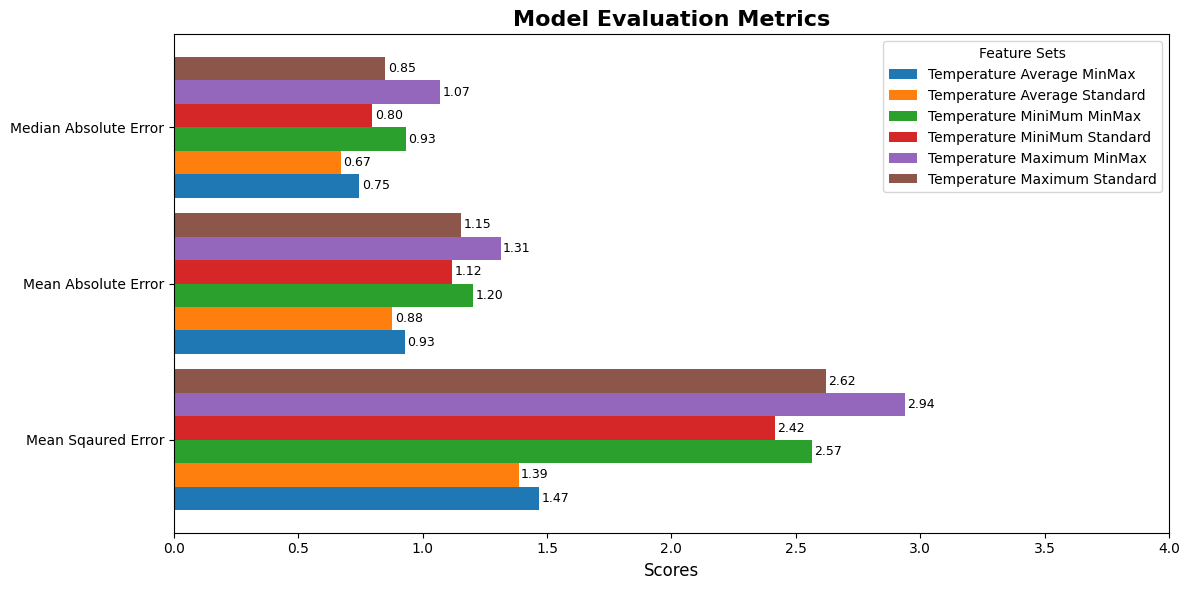

In [571]:
metrics_dicts = [
    temp_avg_minmax, temp_avg_Standard,
    temp_min_minmax, temp_min_Standard,
    temp_max_minmax, temp_max_standard
]
features = [
    "Temperature Average MinMax", "Temperature Average Standard",
    "Temperature MiniMum MinMax", "Temperature MiniMum Standard",
    "Temperature Maximum MinMax", "Temperature Maximum Standard"
]

# Display all metrics in a single plot
display_all_metrics(metrics_dicts, features)

 <h1 style="text-align:center;">END</h1>

---